In [1]:
import sqlite3
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
conn = sqlite3.connect('fsa_new.db')
cur = conn.cursor()

# Defining the Target Variable : Amount

## 1. 1 Filter Healthcare Related Expenses

In [3]:
df_et = pd.read_sql_query('Select hashed_owner_id, pretax_category_truth_label, amount, date From Transactions', conn)
df_et.rename({'hashed_owner_id':'emp_id', 'pretax_category_truth_label':'category'}, axis=1, inplace=True)

# Convert amount to dollars from cents
df_et['amount'] = np.float64(df_et['amount']/100)

df_et['date'] = pd.to_datetime(df_et['date'])
df_et['month_year'] = df_et['date'].dt.to_period('M')

In [4]:
condition = (df_et['category'] == 'healthcare') | (df_et['category'] == 'vision') | (df_et['category'] == 'dental')
df_et = df_et[condition]

# 1. 2 Aggregate monthly transactions

In [5]:
df1 = df_et[['emp_id', 'month_year', 'amount']]

df2 = df1.groupby(['emp_id', 'month_year']).agg({'amount':'sum'}).reset_index()

# 1. 3 Create Sliding Windows For Yearly Transactions

In [6]:
#df2_copy = df2[df2['emp_id']== 'zpq952vtWYRshnAjfJ3S/fFQQ2mLiPj/fwyVnLHrLxw=']

df3 = deepcopy(df2)

df3['start_date'] = df3['month_year'].dt.strftime('%Y-%m').add('-01')

df3['start_date'] = pd.to_datetime(df3['start_date'])
df3['end_date'] = df3['start_date'] + pd.DateOffset(years=1)
df3['date'] = df3['month_year'].dt.strftime('%Y-%m').add('-01')
df3['date'] = pd.to_datetime(df3['date'])

# 1. 4 Determine Last Date of Transaction for Each Employee

In [7]:
df4 = df3[['emp_id', 'date']]

df5 = deepcopy(df4)

df5['max_date'] =  df5.groupby('emp_id')['date'].transform(max)
df5.drop(columns=['date'], inplace=True)

df6 = df3.merge(df5, on='emp_id', how='inner')
df7  = df6.drop_duplicates()

# 1. 5 Compute Average Yearly Transactions 

In [8]:
def groupby_rolling(grp_df):


    df1 = grp_df.apply(lambda x : grp_df.loc[(grp_df.date >= x.start_date)
        & (grp_df.date <=x.end_date), 'amount'].sum(), axis=1)
    df2 = grp_df.apply(lambda x: grp_df.loc[(grp_df.date >= x.start_date) &
                                            (grp_df.date <= x.end_date), 'amount'].count(), axis=1)

    df3 = pd.DataFrame({'amountSum':df1, 'periodCount':df2, 'emp_id':grp_df['emp_id']})
    
    
    df3['avg_amount'] = 12*df3['amountSum']/df3['periodCount']
    df4 = df3.groupby('emp_id').agg({'avg_amount':'mean'}).reset_index()


    return df4

df8 = df7.groupby("emp_id").apply(groupby_rolling).drop(columns=['emp_id']).reset_index().drop(columns=['level_1'])

# 1. 6 Retain Transactions that are Non Negative and Below $3,000 (Max FSA)

In [9]:
df8 = df8[(df8['avg_amount'] > 0) & (df8['avg_amount'] < 3000)]

# 1. 7. Distribution of Yearly Transactions (Amount)

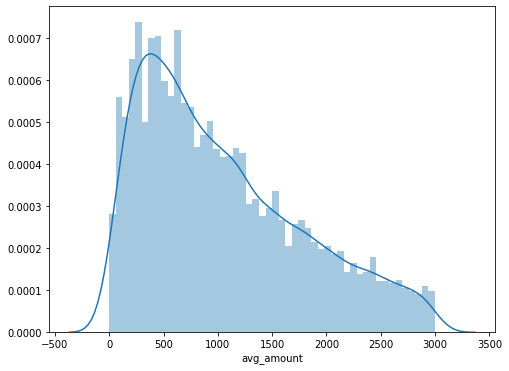

In [11]:
plt.figure(figsize=(8, 6))
plt.tight_layout()
sns.distplot(df8['avg_amount'], bins=50)
plt.show()

# 1. 8 Employees with Zero Spend and 12 months of Transactions

In [ ]:
df_et1 = pd.read_sql_query('Select hashed_owner_id, pretax_category_truth_label, amount, date From Transactions', conn)
df_et1.rename({'hashed_owner_id':'emp_id', 'pretax_category_truth_label':'category'}, axis=1, inplace=True)
    

# Filter Healthcare Related Expenses
condition = (df_et1['category'] == 'healthcare') | (df_et1['category'] == 'vision') | (df_et1['category'] == 'dental')
df_et1 = df_et1[~condition]

df_et1['date'] = pd.to_datetime(df_et1['date'])
df_et1['year'] = pd.DatetimeIndex(df_et1['date']).year
df_et1['month'] = pd.DatetimeIndex(df_et1['date']).month

df1 = df_et1[['emp_id', 'month', 'year']]
df2 = df1.drop_duplicates()

## 1. 8. 1 Filter Employees with 12 months of Transactions

In [ ]:
# Count the number of monthly transactions
df3 = df2.groupby(['emp_id', 'year']).agg(transactions=('month', 'count')).reset_index()

# Retain employees with at least 12  months of transaction data
df3 =  df3[df3['transactions'] == 12]
df3['amount'] = 0.0
df3.drop(columns=['transactions', 'year'], inplace=True)

nospend = df3.copy()

# 1. 8 Group Transactions into Different Categories

## 1. 8. 1 Breakpoints

In [24]:
breakpoints = [750, 1500]; nclasses = 3 # Multi-Class Classification (0, 1, 2)

## 1. 8. 2 Distribution of Classes

In [ ]:
spend = df8.copy()

df = spend[spend['avg_amount'] > 0]


max_amt =  df['avg_amount'].describe()['max']
breakpoints.insert(1, 0)
breakpoints.append(max_amt)

df['amount_range'] = pd.cut(df['avg_amount'], bins=sorted(breakpoints))
df['target'] = df['amount_range'].apply(lambda x : x.mid)

df.drop(columns=['avg_amount', 'amount_range'], inplace=True)
df.rename({'target':'amount'}, axis=1, inplace=True)

df['amount'] = np.float64(df['amount'])

plt.figure(figsize=(8, 6))
plt.tight_layout()
sns.distplot(df['amount'], bins=50)
plt.show()

In [ ]:
print("Average Amount Spent Employees in each class", df['amount'].unique())

amt_vals = sorted(df['amount'].unique())
diff = np.diff(amt_vals)
threshold = 100
for i, num in enumerate(diff):
    if num < threshold:
        df['amount'] = np.where(df['amount'] == amt_vals[i], amt_vals[i+1], df['amount'])
        amt_vals.remove(amt_vals[i])

print("Number of Employees in Each Class ", df['amount'].value_counts())

class_labels = list(range(nclasses))
df['amount'] = df['amount'].map(dict(zip(amt_vals, class_labels)))

## 1. 8. 3 Include Zero Spend Employees

In [ ]:
###### add_nospend = True

if add_nospend ==  True:


    df_spend0 = spend[spend['avg_amount'] == 0.0]

    df2 = deepcopy(nospend)
    df3 = deepcopy(df_spend0)
    df3.rename({'avg_amount':'amount'}, axis=1, inplace=True)

    df4 = pd.concat([df2,  df3])

    df4['amount'] = min(class_labels)

    df5 =  pd.concat([df,  df4])